### Comparing CIFAR 10 and CIFAR 10.1 Testsets

The team observed that the testsets do not contain equal numbers of images.  The CIFAR 10 testset consists of 10k images whereas the CIFAR 10.1 testset consists of 2k images.  We explored this difference as a potential contributor to the distribution gap.  We wondered if, by chance, is the CIFAR 10.1 testset disproportionately composed of fringe images or difficult images.  

We thus run an initial experiment to explore the variance in accuracy scores we see when randomly selecting 2k images from the CIFAR 10 testset as a subset for evaluation.  We bootstrap this setup and repeat the experiment 300 times, to generate 300 random 2k testsets from the CIFAR 10 testset, and score our results on predicting each.  We select the WRN model to run this experiment with.

The results of the experiment are displayed at the end of the notebook with a visualization of the observed accuracy distribution.  We never came close to observing the accuracy score we see when using the CIFAR 10.1 testset



#### Install Libraries and Packages

In [14]:
import boto3
import numpy 
import sagemaker
from sagemaker.pytorch import PyTorch
import torch
import os
import pandas as pd
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Sagemaker Notebook must be of type, conda_pytorch_p36

!pip install -r '/home/ec2-user/SageMaker/w210-capstone/models/pytorch_imageclass/requirements.txt'
!pip install tensorboard

#### Repeatedly Create 2K Subsets of CIFAR 10 Testset and Evaluate


In [6]:
# Download S3 checkpoint file:
bucket='sagemaker-june29'
prefix = 'sagemaker/results/original-models/wrn_28_10'
path = '/home/ec2-user/SageMaker/experiments/wrn_28_10'

s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(prefix + '/checkpoint_00200.pth', '/home/ec2-user/SageMaker/experiments/wrn_28_10/checkpoint_00200.pth')

In [8]:
%%capture cap --no-stderr

result = None

os.chdir('/home/ec2-user/SageMaker/w210-capstone/models/pytorch_imageclass/')

for i in range(300):
    folder = '/home/ec2-user/SageMaker/experiments/wrn_28_10/exp00/cifar10_2k_results_' + str(i)
    !python evaluate.py --config configs/cifar/wrn.yaml \
       model.wrn.depth 28 \
       model.wrn.widening_factor 10 \
       dataset.name CIFAR10_2k \
       test.checkpoint /home/ec2-user/SageMaker/experiments/wrn_28_10/exp00/checkpoint_00200.pth \
       test.output_dir $folder
    
with open('output.txt', 'w') as f:
     f.write(cap.stdout)
        
p = re.compile("Loss (.*) Accuracy (.*)\r")
result = p.findall(cap.stdout)
df = pd.DataFrame(result, columns =['Loss', 'Accuracy'])
df.to_csv('/home/ec2-user/SageMaker/experiments/wrn_28_10/cifar10_2k_results.csv')

#### Results Analysis

In [20]:
print(df[["Loss", "Accuracy"]].describe())

             Loss    Accuracy
count  300.000000  300.000000
mean     0.176142    0.957775
std      0.018090    0.003996
min      0.128300    0.947000
25%      0.164175    0.955000
50%      0.177050    0.958000
75%      0.187475    0.960500
max      0.226400    0.967000


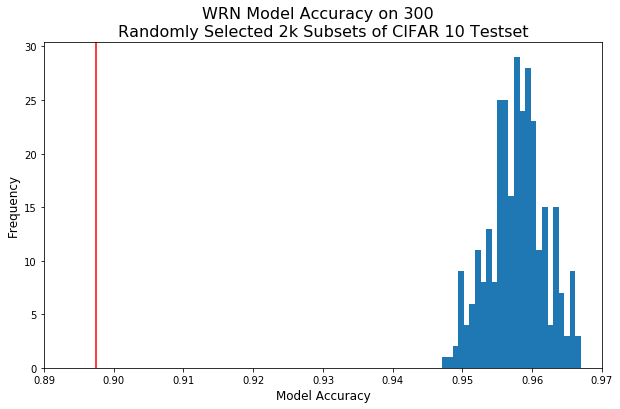

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim((.89,.97))
ax.hist(df.Accuracy, bins=25)

plt.xlabel('Model Accuracy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('WRN Model Accuracy on 300  \nRandomly Selected 2k Subsets of CIFAR 10 Testset', fontsize=16)

ax.axvline(.8975, 0, 70, label='Accuracy on CIFAR 10.1 Testset', color='red')
#plt.legend(loc='upper right');
plt.show()

pass